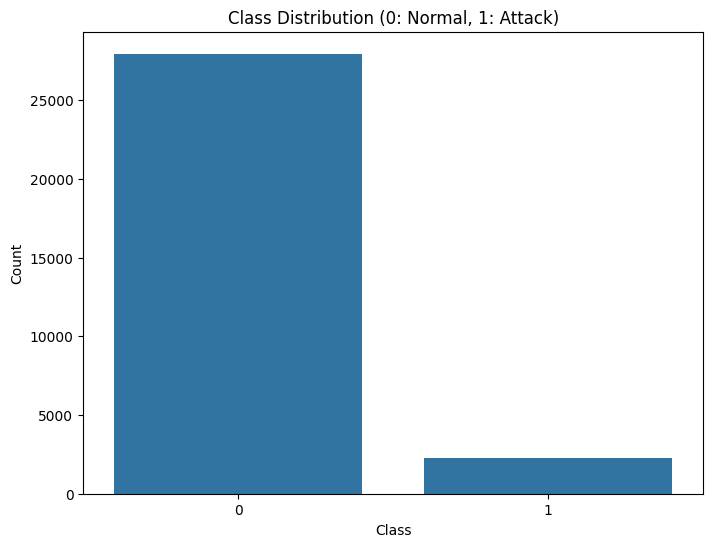

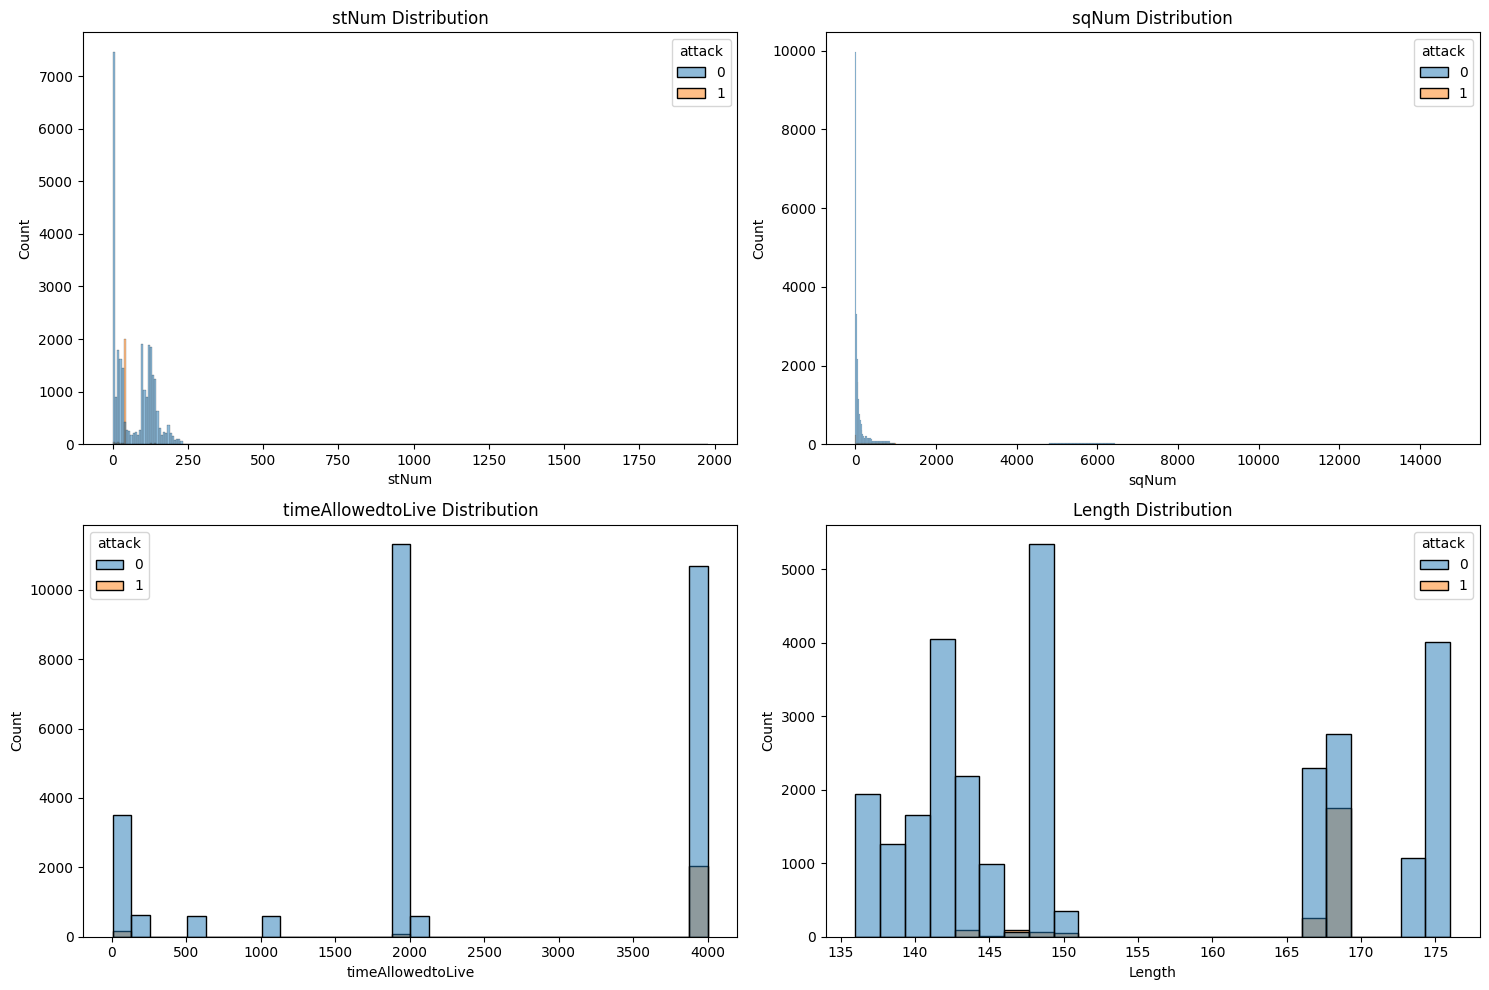

<Axes: >

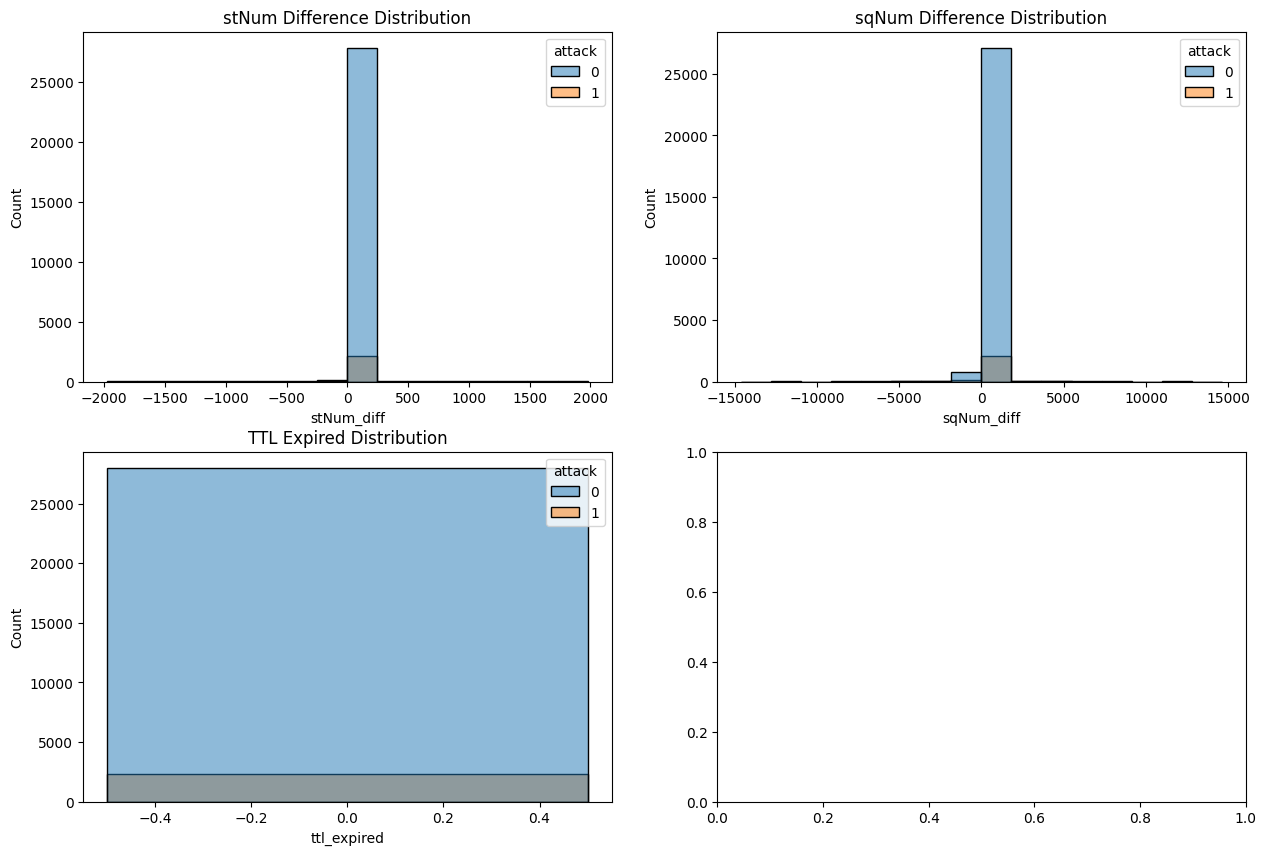

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# List of train and test files with full paths
train_files = [
    '/content/poisioning_labelled_train.csv',
    '/content/masquerade_labelled_train.csv',
    '/content/injection_labelled_train.csv',
    '/content/replay_labelled_train.csv'
]
test_files = [
    '/content/poisioning_labelled_test.csv',
    '/content/masquerade_labelled_test.csv',
    '/content/injection_labelled_test.csv',
    '/content/replay_labelled_test.csv'
]

# Load train data
train_dfs = [pd.read_csv(f) for f in train_files]
train_df = pd.concat(train_dfs, ignore_index=True)
labels_train = train_df['attack']
train_df = train_df.drop('attack', axis=1)

# Load test data
test_dfs = [pd.read_csv(f) for f in test_files]
test_df = pd.concat(test_dfs, ignore_index=True)
labels_test = test_df['attack']
test_df = test_df.drop('attack', axis=1)

# Drop irrelevant columns
drop_cols = [
    'No.', 'Time', 'Protocol', 'Frame', 'Interface id', 'Interface name', 'Interface description',
    'Encapsulation type', 'Arrival Time', 'Simulated', 'simulation', 'Info', 'Epoch Time',
    'Time shift for this packet', 'Time delta from previous captured frame',
    'Time delta from previous displayed frame', 'Time since reference or first frame',
    'Frame Number', 'Frame length on the wire', 'Frame length stored into the capture file'
]
train_df = train_df.drop(columns=[c for c in drop_cols if c in train_df.columns])
test_df = test_df.drop(columns=[c for c in drop_cols if c in test_df.columns])

# Feature Engineering
train_df['stNum_diff'] = train_df.groupby('gocbRef')['stNum'].diff().fillna(0)
train_df['sqNum_diff'] = train_df.groupby('gocbRef')['sqNum'].diff().fillna(0)
train_df['ttl_expired'] = (train_df['timeAllowedtoLive'] <= 0).astype(int)
train_df['packet_rate'] = 1 / train_df['timeAllowedtoLive'].replace(0, 1e-6)  # Avoid division by zero
train_df['length_anomaly'] = (train_df['Length'] - train_df['Length'].mean()) / train_df['Length'].std()

test_df['stNum_diff'] = test_df.groupby('gocbRef')['stNum'].diff().fillna(0)
test_df['sqNum_diff'] = test_df.groupby('gocbRef')['sqNum'].diff().fillna(0)
test_df['ttl_expired'] = (test_df['timeAllowedtoLive'] <= 0).astype(int)
test_df['packet_rate'] = 1 / test_df['timeAllowedtoLive'].replace(0, 1e-6)
test_df['length_anomaly'] = (test_df['Length'] - test_df['Length'].mean()) / test_df['Length'].std()

# EDA: Class Distribution
plt.figure(figsize=(8, 6))
sns.countplot(x=labels_train)
plt.title('Class Distribution (0: Normal, 1: Attack)')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

# EDA: Feature Distributions
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
sns.histplot(data=train_df, x='stNum', hue=labels_train)
plt.title('stNum Distribution')

plt.subplot(2, 2, 2)
sns.histplot(data=train_df, x='sqNum', hue=labels_train)
plt.title('sqNum Distribution')

plt.subplot(2, 2, 3)
sns.histplot(data=train_df, x='timeAllowedtoLive', hue=labels_train)
plt.title('timeAllowedtoLive Distribution')

plt.subplot(2, 2, 4)
sns.histplot(data=train_df, x='Length', hue=labels_train)
plt.title('Length Distribution')

plt.tight_layout()
plt.show()

# EDA: Engineered Feature Distributions
plt.figure(figsize=(15, 10))

plt.subplot(2, 2, 1)
sns.histplot(data=train_df, x='stNum_diff', hue=labels_train)
plt.title('stNum Difference Distribution')

plt.subplot(2, 2, 2)
sns.histplot(data=train_df, x='sqNum_diff', hue=labels_train)
plt.title('sqNum Difference Distribution')

plt.subplot(2, 2, 3)
sns.histplot(data=train_df, x='ttl_expired', hue=labels_train)
plt.title('TTL Expired Distribution')

plt.subplot(2, 2, 4)


In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import altair as alt

# --- 1. Define File Paths (Crucial: Use the full file path for loading) ---
file_paths = [
    "masquerade_labelled_test.csv",
    "poisioning_labelled_test.csv",
    "injection_labelled_test.csv",
    "replay_labelled_test.csv",
    "poisioning_labelled_train.csv",
    "injection_labelled_train.csv",
    "replay_labelled_train.csv",
    "masquerade_labelled_train.csv",
]

# --- 2. Load and Combine DataFrames ---
df_list = []
for file in file_paths:
    try:
        # pd.read_csv uses the full path to successfully load the file
        df = pd.read_csv(file)
        # Extract the attack type (e.g., 'masquerade') from the file name
        attack_name = file.split('/')[-1].split('_labelled')[0]
        df['File_Attack_Type'] = attack_name
        df_list.append(df)
    except Exception as e:
        print(f"Error loading {file}: {e}")

df_combined = pd.concat(df_list, ignore_index=True)


# --- 3. Feature Engineering ---
# Create 'Attack_Category': 'Normal' for attack=0, otherwise capitalized attack name
df_combined['Attack_Category'] = np.where(
    df_combined['attack'] == 1,
    df_combined['File_Attack_Type'].str.capitalize(),
    'Normal'
)

# Clean up column with all null values
if 'Info' in df_combined.columns:
    df_combined = df_combined.drop(columns=['Info'])


# --- 4. Define Features for Plotting ---
numerical_cols = [
    'Length',
    'stNum',
    'sqNum',
    'Time delta from previous captured frame',
    'Time since reference or first frame'
]
pairplot_cols = numerical_cols + ['Attack_Category']

# --- 5. Sampling for Pairplot (5,000 rows) ---
# Sample is required because plotting 60,000+ data points is slow and dense.
df_sample = df_combined[pairplot_cols].sample(n=5000, random_state=42)

# --- 6. Generate Pairplot (Seaborn) ---
print("Generating Pairplot...")
plt.figure(figsize=(15, 15))
pair_plot = sns.pairplot(
    df_sample,
    hue='Attack_Category',
    diag_kind='kde', # Kernel Density Estimate on the diagonal
    palette='deep',
    plot_kws={'alpha': 0.6, 's': 10}
)
pair_plot.fig.suptitle("Pairplot of Selected Features by Attack Category (5000 Samples)", y=1.02, fontsize=16)
plt.savefig('pairplot_selected_features.png')
plt.close()
print("Pairplot saved as: pairplot_selected_features.png")


# --- 7. Generate Focused Scatterplot (Altair, 10,000 rows) ---
# Focus on stNum and sqNum for interactive analysis.
df_scatter_sample = df_combined.sample(n=10000, random_state=42)

# scatter_chart = alt.Chart(df_scatter_sample).mark_circle(size=60).encode(
#     x=alt.X('stNum', title='State Number (stNum)'),
#     y=alt.Y('sqNum', title='Sequence Number (sqNum)'),
#     color=alt.Color('Attack_Category', title='Attack Type'),
#     tooltip=['Attack_Category', 'stNum', 'sqNum', 'Length']
# ).properties(
#     title='stNum vs sqNum by Attack Category (10,000 Samples)'
# ).interactive() # Allows interactive zooming and panning
# scatter_chart.save('stnum_sqnum_scatterplot.json')
# print("Interactive scatterplot saved as: stnum_sqnum_scatterplot.json")
plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='stNum',
    y='sqNum',
    hue='Attack_Category',
    data=df_scatter_sample,
    palette='deep',
    s=20, # marker size
    alpha=0.6
)

plt.title('stNum vs sqNum by Attack Category (10,000 Samples)', fontsize=14)
plt.xlabel('State Number (stNum)')
plt.ylabel('Sequence Number (sqNum)')
# Place the legend outside the plot area
plt.legend(title='Attack Type', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)

static_scatter_filename = 'stnum_sqnum_static_scatterplot.png'
plt.savefig(static_scatter_filename, bbox_inches='tight')
plt.close()

print(f"Static scatterplot saved as: {static_scatter_filename}")

Generating Pairplot...
Pairplot saved as: pairplot_selected_features.png
Static scatterplot saved as: stnum_sqnum_static_scatterplot.png


<Figure size 1500x1500 with 0 Axes>

In [ ]:
#K-means
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.impute import SimpleImputer

# List of train and test files with full paths
train_files = [
    '/content/poisioning_labelled_train.csv',
    '/content/masquerade_labelled_train.csv',
    '/content/injection_labelled_train.csv',
    '/content/replay_labelled_train.csv'
]
test_files = [
    '/content/poisioning_labelled_test.csv',
    '/content/masquerade_labelled_test.csv',
    '/content/injection_labelled_test.csv',
    '/content/replay_labelled_test.csv'
]

# Load train data
train_dfs = [pd.read_csv(f) for f in train_files]
train_df = pd.concat(train_dfs, ignore_index=True)
labels_train = train_df['attack']
train_df = train_df.drop('attack', axis=1)

# Load test data
test_dfs = [pd.read_csv(f) for f in test_files]
test_df = pd.concat(test_dfs, ignore_index=True)
labels_test = test_df['attack']
test_df = test_df.drop('attack', axis=1)

# Drop irrelevant columns
drop_cols = [
    'No.', 'Time', 'Protocol', 'Frame', 'Interface id', 'Interface name', 'Interface description',
    'Encapsulation type', 'Arrival Time', 'Simulated', 'simulation', 'Info', 'Epoch Time',
    'Time shift for this packet', 'Time delta from previous captured frame',
    'Time delta from previous displayed frame', 'Time since reference or first frame',
    'Frame Number', 'Frame length on the wire', 'Frame length stored into the capture file'
]
train_df = train_df.drop(columns=[c for c in drop_cols if c in train_df.columns])
test_df = test_df.drop(columns=[c for c in drop_cols if c in test_df.columns])

# Separate numeric and categorical columns
numeric_cols = train_df.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = train_df.select_dtypes(include=['object']).columns

# Impute numeric columns
numeric_imputer = SimpleImputer(strategy='median')
train_df[numeric_cols] = numeric_imputer.fit_transform(train_df[numeric_cols])
test_df[numeric_cols] = numeric_imputer.transform(test_df[numeric_cols])

# Impute categorical columns (using mode for strings)
categorical_imputer = SimpleImputer(strategy='most_frequent')
train_df[categorical_cols] = categorical_imputer.fit_transform(train_df[categorical_cols])
test_df[categorical_cols] = categorical_imputer.transform(test_df[categorical_cols])

# Feature Engineering with NaN handling
train_df['stNum_diff'] = train_df.groupby('gocbRef')['stNum'].diff().fillna(0)
train_df['sqNum_diff'] = train_df.groupby('gocbRef')['sqNum'].diff().fillna(0)
train_df['ttl_expired'] = (train_df['timeAllowedtoLive'] <= 0).astype(int)
train_df['packet_rate'] = 1 / train_df['timeAllowedtoLive'].replace(0, 1e-6)  # Avoid division by zero
train_df['length_anomaly'] = (train_df['Length'] - train_df['Length'].mean()) / train_df['Length'].std()

test_df['stNum_diff'] = test_df.groupby('gocbRef')['stNum'].diff().fillna(0)
test_df['sqNum_diff'] = test_df.groupby('gocbRef')['sqNum'].diff().fillna(0)
test_df['ttl_expired'] = (test_df['timeAllowedtoLive'] <= 0).astype(int)
test_df['packet_rate'] = 1 / test_df['timeAllowedtoLive'].replace(0, 1e-6)
test_df['length_anomaly'] = (test_df['Length'] - test_df['Length'].mean()) / test_df['Length'].std()

# Identify categorical columns excluding 'gocbRef' for encoding
cat_cols = [col for col in train_df.select_dtypes(include=['object']).columns if col != 'gocbRef']

# Label encode categorical columns
for col in cat_cols:
    le = LabelEncoder()
    combined = pd.concat([train_df[col].astype(str), test_df[col].astype(str)])
    le.fit(combined)
    train_df[col] = le.transform(train_df[col].astype(str))
    test_df[col] = le.transform(test_df[col].astype(str))

# Identify numerical columns
num_cols = train_df.select_dtypes(include=['float64', 'int64']).columns

# Scale numerical features
scaler = StandardScaler()
train_df[num_cols] = scaler.fit_transform(train_df[num_cols])
test_df[num_cols] = scaler.transform(test_df[num_cols])

# Model
kmeans_model = KMeans(n_clusters=2, random_state=42)
kmeans_model.fit(train_df.drop('gocbRef', axis=1))
kmeans_preds = kmeans_model.predict(test_df.drop('gocbRef', axis=1))

# Map clusters to labels (heuristic based on training data)
cluster_labels = {}
cluster0_label = 0 if labels_train[kmeans_model.labels_ == 0].mean() < 0.5 else 1
cluster1_label = 0 if labels_train[kmeans_model.labels_ == 1].mean() < 0.5 else 1
cluster_labels[0] = cluster0_label
cluster_labels[1] = cluster1_label
kmeans_preds = [cluster_labels[x] for x in kmeans_preds]

# Evaluate
metrics = {
    'Accuracy': accuracy_score(labels_test, kmeans_preds),
    'Precision': precision_score(labels_test, kmeans_preds, zero_division=0),
    'Recall': recall_score(labels_test, kmeans_preds, zero_division=0),
    'F1-Score': f1_score(labels_test, kmeans_preds, zero_division=0)
}
print("K-means Metrics:", metrics)


K-means Metrics: {'Accuracy': 0.9239719687954515, 'Precision': 0.0, 'Recall': 0.0, 'F1-Score': 0.0}


In [ ]:
#GMM model
import pandas as pd
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.mixture import GaussianMixture
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load and preprocess (same as above)

# List of train and test files with full paths
train_files = [
    '/content/poisioning_labelled_train.csv',# copy your file path
    '/content/masquerade_labelled_train.csv',
    '/content/injection_labelled_train.csv',
    '/content/replay_labelled_train.csv'
]
test_files = [
    '/content/poisioning_labelled_test.csv',
    '/content/masquerade_labelled_test.csv',
    '/content/injection_labelled_test.csv',
    '/content/replay_labelled_test.csv'
]

# Load train data
train_dfs = [pd.read_csv(f) for f in train_files]
train_df = pd.concat(train_dfs, ignore_index=True)
labels_train = train_df['attack']
train_df = train_df.drop('attack', axis=1)

# Load test data
test_dfs = [pd.read_csv(f) for f in test_files]
test_df = pd.concat(test_dfs, ignore_index=True)
labels_test = test_df['attack']
test_df = test_df.drop('attack', axis=1)

# Drop irrelevant columns
drop_cols = [
    'No.', 'Time', 'Protocol', 'Frame', 'Interface id', 'Interface name', 'Interface description',
    'Encapsulation type', 'Arrival Time', 'Simulated', 'simulation', 'Info', 'Epoch Time',
    'Time shift for this packet', 'Time delta from previous captured frame',
    'Time delta from previous displayed frame', 'Time since reference or first frame',
    'Frame Number', 'Frame length on the wire', 'Frame length stored into the capture file'
]
train_df = train_df.drop(columns=[c for c in drop_cols if c in train_df.columns])
test_df = test_df.drop(columns=[c for c in drop_cols if c in test_df.columns])

# Separate numeric and categorical columns
numeric_cols = train_df.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = train_df.select_dtypes(include=['object']).columns

# Impute numeric columns
numeric_imputer = SimpleImputer(strategy='median')
train_df[numeric_cols] = numeric_imputer.fit_transform(train_df[numeric_cols])
test_df[numeric_cols] = numeric_imputer.transform(test_df[numeric_cols])

# Impute categorical columns (using mode for strings)
categorical_imputer = SimpleImputer(strategy='most_frequent')
train_df[categorical_cols] = categorical_imputer.fit_transform(train_df[categorical_cols])
test_df[categorical_cols] = categorical_imputer.transform(test_df[categorical_cols])

# Feature Engineering with NaN handling
train_df['stNum_diff'] = train_df.groupby('gocbRef')['stNum'].diff().fillna(0)
train_df['sqNum_diff'] = train_df.groupby('gocbRef')['sqNum'].diff().fillna(0)
train_df['ttl_expired'] = (train_df['timeAllowedtoLive'] <= 0).astype(int)
train_df['packet_rate'] = 1 / train_df['timeAllowedtoLive'].replace(0, 1e-6)  # Avoid division by zero
train_df['length_anomaly'] = (train_df['Length'] - train_df['Length'].mean()) / train_df['Length'].std()

test_df['stNum_diff'] = test_df.groupby('gocbRef')['stNum'].diff().fillna(0)
test_df['sqNum_diff'] = test_df.groupby('gocbRef')['sqNum'].diff().fillna(0)
test_df['ttl_expired'] = (test_df['timeAllowedtoLive'] <= 0).astype(int)
test_df['packet_rate'] = 1 / test_df['timeAllowedtoLive'].replace(0, 1e-6)
test_df['length_anomaly'] = (test_df['Length'] - test_df['Length'].mean()) / test_df['Length'].std()

# Identify categorical columns excluding 'gocbRef' for encoding
cat_cols = [col for col in train_df.select_dtypes(include=['object']).columns if col != 'gocbRef']

# Label encode categorical columns
for col in cat_cols:
    le = LabelEncoder()
    combined = pd.concat([train_df[col].astype(str), test_df[col].astype(str)])
    le.fit(combined)
    train_df[col] = le.transform(train_df[col].astype(str))
    test_df[col] = le.transform(test_df[col].astype(str))

# Identify numerical columns
num_cols = train_df.select_dtypes(include=['float64', 'int64']).columns

# Scale numerical features
scaler = StandardScaler()
train_df[num_cols] = scaler.fit_transform(train_df[num_cols])
test_df[num_cols] = scaler.transform(test_df[num_cols])

# Model
gmm_model = GaussianMixture(n_components=2, random_state=42)
gmm_model.fit(train_df.drop('gocbRef', axis=1))
gmm_preds = gmm_model.predict(test_df.drop('gocbRef', axis=1))
# Map components (refine with validation)
component_labels = {0: 0, 1: 1}  # Placeholder, adjust based on validation
gmm_preds = [component_labels[x] for x in gmm_preds]

# Evaluate
metrics = {
    'Accuracy': accuracy_score(labels_test, gmm_preds),
    'Precision': precision_score(labels_test, gmm_preds, zero_division=0),
    'Recall': recall_score(labels_test, gmm_preds, zero_division=0),
    'F1-Score': f1_score(labels_test, gmm_preds, zero_division=0)
}
print("GMM Metrics:", metrics)

GMM Metrics: {'Accuracy': 0.6562541319582177, 'Precision': 0.16530291759649557, 'Recall': 0.8695652173913043, 'F1-Score': 0.2777970692409195}


In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import IsolationForest
from sklearn.metrics import classification_report
import numpy as np

y_binary = df_combined['attack']
y_multi = df_combined['Attack_Category']
X_all = df_combined[numerical_cols].copy()

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_all)
X_scaled_df = pd.DataFrame(X_scaled, columns=numerical_cols)

# --- 3. Split Data ---
# Split data into scaled features, binary labels, unscaled features, and multi-class labels for training/testing
X_scaled_train, X_scaled_test, y_binary_train, y_binary_test, \
    X_unscaled_train, X_unscaled_test, y_multi_train, y_multi_test = \
    train_test_split(X_scaled_df, y_binary, X_all, y_multi,
                     test_size=0.3, random_state=42, stratify=y_multi)

X_scaled_train_np = X_scaled_train.values
X_scaled_test_np = X_scaled_test.values

# --- 4. Fit Isolation Forest and Predict ---
# Calculate contamination rate from training set
anomaly_rate = y_binary_train.sum() / len(y_binary_train)

model_if = IsolationForest(
    contamination=anomaly_rate,
    random_state=42,
    n_estimators=100,
    n_jobs=-1
)
model_if.fit(X_scaled_train_np)

# Calculate the decision boundary threshold from the training data scores
anomaly_scores_train = model_if.decision_function(X_scaled_train_np)
threshold = np.percentile(anomaly_scores_train, 100 * anomaly_rate)

# Predict scores and labels on the test set
anomaly_scores = model_if.decision_function(X_scaled_test_np)
y_pred_if = model_if.predict(X_scaled_test_np) # -1 is anomaly, 1 is normal
y_pred_if_binary = np.where(y_pred_if == -1, 1, 0) # 1 = Anomaly, 0 = Normal

# --- 5. Classification Report ---
print("\n--- Isolation Forest Classification Report (Binary: Normal vs. Attack) ---")
report = classification_report(y_binary_test, y_pred_if_binary, target_names=['Normal', 'Attack'], digits=4)
print(report)

# --- 6. Plot 1: Anomaly Score Distribution (KDE) ---
print("\nGenerating Anomaly Score Distribution Plot...")
df_scores = pd.DataFrame({
    'Anomaly_Score': anomaly_scores,
    'True_Label': y_binary_test.map({0: 'Normal', 1: 'Attack'})
})

plt.figure(figsize=(9, 6))
sns.kdeplot(
    data=df_scores,
    x='Anomaly_Score',
    hue='True_Label',
    fill=True,
    common_norm=False,
    palette={'Normal': 'skyblue', 'Attack': 'red'},
    linewidth=2
)
plt.axvline(x=threshold, color='k', linestyle='--', label=f'Decision Boundary: {threshold:.3f}')
plt.title('Isolation Forest Anomaly Score Distribution', fontsize=14)
plt.xlabel('Anomaly Score (Lower = More Anomalous)')
plt.ylabel('Density')
plt.legend(title='True Class')
plt.tight_layout()
plt.savefig('if_anomaly_score_distribution.png')
plt.close()
print("Plot 1 saved as: if_anomaly_score_distribution.png")

# --- 7. Plot 2: Feature Space Visualization (stNum vs sqNum) ---
print("Generating 2D Feature Space Plot...")
df_plot = X_unscaled_test[['stNum', 'sqNum']].copy()
df_plot['IF_Prediction'] = np.where(y_pred_if_binary == 1, 'Predicted Anomaly', 'Predicted Normal')
df_plot['True_Label'] = y_multi_test.reset_index(drop=True)

# Sample the data for a clearer plot (10k points)
df_plot_sample = df_plot.sample(n=10000, random_state=42)

plt.figure(figsize=(10, 8))
sns.scatterplot(
    x='stNum',
    y='sqNum',
    hue='IF_Prediction',
    data=df_plot_sample,
    style='True_Label',
    palette={'Predicted Anomaly': 'red', 'Predicted Normal': 'skyblue'},
    s=30,
    alpha=0.6
)

plt.title('Isolation Forest Prediction in Feature Space (stNum vs sqNum)', fontsize=14)
plt.xlabel('State Number (stNum)')
plt.ylabel('Sequence Number (sqNum)')
plt.legend(title='Legend', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig('if_feature_space_visualization.png')
plt.close()
print("Plot 2 saved as: if_feature_space_visualization.png")


--- Isolation Forest Classification Report (Binary: Normal vs. Attack) ---
              precision    recall  f1-score   support

      Normal     0.9214    0.9193    0.9203     16773
      Attack     0.0451    0.0464    0.0457      1380

    accuracy                         0.8529     18153
   macro avg     0.4832    0.4828    0.4830     18153
weighted avg     0.8548    0.8529    0.8538     18153


Generating Anomaly Score Distribution Plot...
Plot 1 saved as: if_anomaly_score_distribution.png
Generating 2D Feature Space Plot...
Plot 2 saved as: if_feature_space_visualization.png


In [ ]:
#isolation forest
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.model_selection import train_test_split

# List of train and test files with full paths
train_files = [
    '/content/poisioning_labelled_train.csv',
    '/content/masquerade_labelled_train.csv',
    '/content/injection_labelled_train.csv',
    '/content/replay_labelled_train.csv'
]
test_files = [
    '/content/poisioning_labelled_test.csv',
    '/content/masquerade_labelled_test.csv',
    '/content/injection_labelled_test.csv',
    '/content/replay_labelled_test.csv'
]

# Load train data
train_dfs = [pd.read_csv(f) for f in train_files]
train_df = pd.concat(train_dfs, ignore_index=True)
labels_train = train_df['attack']
train_df = train_df.drop('attack', axis=1)

# Load test data
test_dfs = [pd.read_csv(f) for f in test_files]
test_df = pd.concat(test_dfs, ignore_index=True)
labels_test = test_df['attack']
test_df = test_df.drop('attack', axis=1)

# Drop irrelevant columns
drop_cols = [
    'No.', 'Time', 'Protocol', 'Frame', 'Interface id', 'Interface name', 'Interface description',
    'Encapsulation type', 'Arrival Time', 'Simulated', 'simulation', 'Info', 'Epoch Time',
    'Time shift for this packet', 'Time delta from previous captured frame',
    'Time delta from previous displayed frame', 'Time since reference or first frame',
    'Frame Number', 'Frame length on the wire', 'Frame length stored into the capture file'
]
train_df = train_df.drop(columns=[c for c in drop_cols if c in train_df.columns])
test_df = test_df.drop(columns=[c for c in drop_cols if c in test_df.columns])

# Feature Engineering
train_df['stNum_diff'] = train_df.groupby('gocbRef')['stNum'].diff().fillna(0)
train_df['sqNum_diff'] = train_df.groupby('gocbRef')['sqNum'].diff().fillna(0)
train_df['ttl_expired'] = (train_df['timeAllowedtoLive'] <= 0).astype(int)
train_df['packet_rate'] = 1 / train_df['timeAllowedtoLive'].replace(0, 1e-6)  # Avoid division by zero
train_df['length_anomaly'] = (train_df['Length'] - train_df['Length'].mean()) / train_df['Length'].std()

test_df['stNum_diff'] = test_df.groupby('gocbRef')['stNum'].diff().fillna(0)
test_df['sqNum_diff'] = test_df.groupby('gocbRef')['sqNum'].diff().fillna(0)
test_df['ttl_expired'] = (test_df['timeAllowedtoLive'] <= 0).astype(int)
test_df['packet_rate'] = 1 / test_df['timeAllowedtoLive'].replace(0, 1e-6)
test_df['length_anomaly'] = (test_df['Length'] - test_df['Length'].mean()) / test_df['Length'].std()

# Identify categorical columns excluding 'gocbRef'
cat_cols = [col for col in train_df.select_dtypes(include=['object']).columns if col != 'gocbRef']

# Label encode categorical columns
for col in cat_cols:
    le = LabelEncoder()
    combined = pd.concat([train_df[col].astype(str), test_df[col].astype(str)])
    le.fit(combined)
    train_df[col] = le.transform(train_df[col].astype(str))
    test_df[col] = le.transform(test_df[col].astype(str))

# Identify numerical columns
num_cols = train_df.select_dtypes(include=['float64', 'int64']).columns

# Scale numerical features
scaler = StandardScaler()
train_df[num_cols] = scaler.fit_transform(train_df[num_cols])
test_df[num_cols] = scaler.transform(test_df[num_cols])

# Split train data into train and validation sets
train_data, val_data, train_labels, val_labels = train_test_split(
    train_df, labels_train, test_size=0.2, random_state=42, stratify=labels_train
)

# Train one Isolation Forest model per 'gocbRef' group with tuned contamination
unique_gocb = train_data['gocbRef'].unique()
models = {}
thresholds = {}
for g in unique_gocb:
    mask = train_data['gocbRef'] == g
    train_g = train_data[mask].drop('gocbRef', axis=1)
    train_g_labels = train_labels[mask]
    if len(train_g) > 0:
        contamination = 0.05  # Conservative value
        model = IsolationForest(contamination=contamination, random_state=42)
        model.fit(train_g)
        models[g] = model
        # Tune threshold using validation set
        val_g = val_data[val_data['gocbRef'] == g].drop('gocbRef', axis=1)
        val_g_labels = val_labels[val_data['gocbRef'] == g]
        if len(val_g) > 0:
            scores = model.decision_function(val_g)
            th_range = np.linspace(min(scores), max(scores), 100)
            best_f1 = -1
            best_th = 0.0
            for th in th_range:
                preds_th = (scores < th).astype(int)
                current_f1 = f1_score(val_g_labels, preds_th, zero_division=0)
                if current_f1 > best_f1:
                    best_f1 = current_f1
                    best_th = th
            thresholds[g] = best_th
        else:
            thresholds[g] = np.percentile(model.decision_function(train_g), 10)  # 10th percentile

# Predict on test data
preds = []
for _, row in test_df.iterrows():
    g = row['gocbRef']
    if g in models:
        row_data = pd.DataFrame([row.drop('gocbRef')])
        score = models[g].decision_function(row_data)[0]
        pred = 1 if score < thresholds.get(g, 0.0) else 0
        preds.append(pred)
    else:
        preds.append(0)  # Default to normal if unseen gocbRef

# Evaluate performance
acc = accuracy_score(labels_test, preds)
prec = precision_score(labels_test, preds, zero_division=0)
rec = recall_score(labels_test, preds, zero_division=0)
f1 = f1_score(labels_test, preds, zero_division=0)
print(f'Accuracy: {acc:.4f}')
print(f'Precision: {prec:.4f}')
print(f'Recall: {rec:.4f}')
print(f'F1-Score: {f1:.4f}')

Accuracy: 0.8223
Precision: 0.2978
Recall: 0.9843
F1-Score: 0.4572


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.metrics import confusion_matrix

# --- 1. Load Data (Using Correct Train/Test Split) ---
# NOTE: Using the internal paths that the system correctly recognizes from the zip file.
train_files = [
    "poisioning_labelled_train.csv",
    "injection_labelled_train.csv",
    "replay_labelled_train.csv",
    "masquerade_labelled_train.csv",
]
test_files = [
    "masquerade_labelled_test.csv",
    "poisioning_labelled_test.csv",
    "injection_labelled_test.csv",
    "replay_labelled_test.csv",
]

def load_data(files):
    df_list = []
    for file in files:
        try:
            df = pd.read_csv(file)
            attack_name = file.split('/')[-1].split('_labelled')[0]
            df['File_Attack_Type'] = attack_name
            df_list.append(df)
        except Exception as e:
            print(f"Error loading {file}: {e}")

    if not df_list:
        raise FileNotFoundError("No files could be loaded.")

    df_combined = pd.concat(df_list, ignore_index=True)

    if 'Info' in df_combined.columns:
        df_combined = df_combined.drop(columns=['Info'])

    # Feature Engineering to create the multi-class label
    df_combined['Attack_Category'] = np.where(
        df_combined['attack'] == 1,
        df_combined['File_Attack_Type'].str.capitalize(),
        'Normal'
    )
    return df_combined

df_train_full = load_data(train_files)
df_test_full = load_data(test_files)

# --- 2. Feature Selection and Scaling ---
numerical_features = [
    'Length', 'stNum', 'sqNum', 'Time delta from previous captured frame', 'Time since reference or first frame'
]

X_train_unscaled = df_train_full[numerical_features].copy()
y_train_binary = df_train_full['attack']
X_test_unscaled = df_test_full[numerical_features].copy()
y_test_multi = df_test_full['Attack_Category']

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_unscaled)
X_test_scaled = scaler.transform(X_test_unscaled)

# --- 3. Fit Isolation Forest with INCREASED CONTAMINATION ---
NEW_CONTAMINATION_RATE = 0.15

model_if_tuned = IsolationForest(
    contamination=NEW_CONTAMINATION_RATE,
    random_state=42,
    n_estimators=100,
    n_jobs=-1
)
model_if_tuned.fit(X_train_scaled)

# Predict on the Test Set
y_pred_if_test = model_if_tuned.predict(X_test_scaled)
# GUARANTEE Binary Prediction Labels: 'Anomaly' or 'Normal'
y_pred_if_multi = np.where(y_pred_if_test == -1, 'Anomaly', 'Normal')

# --- 4. Multi-Class Confusion Matrix (to group attack types) ---
true_labels_order = ['Normal', 'Injection', 'Masquerade', 'Poisoning', 'Replay']
predicted_labels_order = ['Normal', 'Anomaly']

# Compute the matrix. The row labels are explicitly set (5 classes).
# The column labels should be the unique labels in y_pred_if_multi (2 classes).
# We must include the predicted labels in the `labels` parameter for correct column mapping.
# The correct order is to list the classes that appear in y_true first, then the ones only in y_pred.
# Since we want to display Normal, Injection, Masquerade, Poisoning, Replay as ROWS,
# and Normal, Anomaly as COLUMNS, we must rely on explicit DataFrame construction.

# Confusion matrix calculation:
cm_multi = confusion_matrix(
    y_test_multi,
    y_pred_if_multi,
    # labels must contain all 5 true classes AND all 2 predicted classes for a square matrix
    # Let's keep the labels argument simple to the rows and rely on pd.DataFrame correction
    labels=true_labels_order # Ensures the 5 true classes are in this row order
)

# However, the previous error implies cm_multi is 5x5, which means confusion_matrix failed.
# Let's use the explicit list of all 5 true labels and 2 predicted labels for *all* classes.
# This forces the matrix to be 7x7, but we can index it. This is more robust.
all_labels = ['Normal', 'Injection', 'Masquerade', 'Poisoning', 'Replay', 'Anomaly']

cm_full = confusion_matrix(
    y_test_multi,
    y_pred_if_multi,
    labels=all_labels
)

# Extract the relevant 5x2 sub-matrix: Rows are the 5 true classes, Columns are 'Normal' and 'Anomaly'
# The indices of the columns we want are 0 ('Normal') and 5 ('Anomaly') in the all_labels list
cm_multi = cm_full[:5, [0, 5]]

# Convert the confusion matrix to a DataFrame for clear display
cm_df = pd.DataFrame(cm_multi,
                     index=[f'True {label}' for label in true_labels_order],
                     columns=['Predicted Normal (0)', 'Predicted Anomaly (1)'])

# Calculate the percentage of samples from each TRUE class that were predicted as ANOMALY (Recall per attack type)
cm_norm_df = cm_df.div(cm_df.sum(axis=1), axis=0) * 100

print("\n--- Isolation Forest Attack Detection Breakdown (Normalized %) - Contamination 15% ---")
print(cm_norm_df)

# Plotting the normalized multi-class confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm_norm_df, annot=True, fmt='.2f', cmap='Blues',
            cbar_kws={'label': 'Percentage of True Class Predicted (%)', 'format': '%.0f%%'},
            linewidths=.5, linecolor='black')
plt.title(f'Isolation Forest Anomaly Detection Breakdown (Contamination: {NEW_CONTAMINATION_RATE*100:.0f}%)', fontsize=14)
plt.ylabel('True Class', fontsize=12)
plt.xlabel('Isolation Forest Prediction', fontsize=12)
plt.yticks(rotation=0)
plt.tight_layout()
plt.savefig('if_multi_class_confusion_matrix_15contam_fixed.png')
plt.close()
print("Multi-Class Confusion Matrix Plot saved as: if_multi_class_confusion_matrix_15contam_fixed.png")


--- Isolation Forest Attack Detection Breakdown (Normalized %) - Contamination 15% ---
                 Predicted Normal (0)  Predicted Anomaly (1)
True Normal                 71.025329              28.974671
True Injection               0.000000             100.000000
True Masquerade             98.000000               2.000000
True Poisoning                    NaN                    NaN
True Replay                 67.000000              33.000000
Multi-Class Confusion Matrix Plot saved as: if_multi_class_confusion_matrix_15contam_fixed.png


Boxplots and histograms

In [ ]:
a=df_train_full.columns.to_list()
print(a)

['Epoch Time', 'gocbRef', 'No.', 'Time', 'Protocol', 'Length', 'APPID', 'goID', 'allData', 'bit-string', 'stNum', 'sqNum', 'confRev', 'datSet', 'Source', 'Destination', 'Frame', 'Interface id', 'Interface name', 'Interface description', 'Encapsulation type', 't', 'Arrival Time', 'Time shift for this packet', 'Time delta from previous captured frame', 'Time delta from previous displayed frame', 'Time since reference or first frame', 'Frame Number', 'Frame length on the wire', 'Frame length stored into the capture file', 'Simulated', 'timeAllowedtoLive', 'simulation', 'ndsCom', 'numDatSetEntries', 'Data', 'Type', 'IG bit', 'Address', 'LG bit', 'IG bit.1', 'LG bit.1', 'Length.1', 'Reserved 1', 'Reserved 2', 'boolean', 'attack', 'File_Attack_Type', 'Attack_Category']


In [ ]:

# ------ 1. Import Libraries ------
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

# ------ 2. Select Numeric Features ------
target_col = 'Attack_Category'
numeric_features = df_train_full.select_dtypes(include='number').columns.tolist()
legitDF = [col for col in numeric_features if col != target_col]

# ------ 3. Drop Missing Values ------
df_clean = df_train_full.dropna(subset=legitDF + [target_col])
print(f"✅ Rows after dropping missing values: {df_clean.shape[0]}")

# ------ 4. Sample for Plotting (Optional) ------
df_sample = df_clean.sample(n=5000, random_state=42)

# ------ 5. Setup Grid Layout ------
num_features = len(legitDF)
cols = 3  # Number of columns in the grid
rows = math.ceil(num_features / cols)

fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
axes = axes.flatten()

# ------ 6. Plot Each Boxplot ------
for i, feature in enumerate(legitDF):
    sns.boxplot(x=target_col, y=feature, data=df_sample, ax=axes[i], palette='Set2')
    axes[i].set_title(f'{feature}', fontsize=12)
    axes[i].tick_params(axis='x', rotation=45)

# Remove unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# ------ 7. Finalize and Save ------
fig.suptitle('Combined Boxplots of Features by Attack Category', fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig('combined_boxplots.png', dpi=300, bbox_inches='tight')
plt.close()
print("📦 Combined boxplot figure saved as: combined_boxplots.png")




✅ Rows after dropping missing values: 12121


/tmp/ipython-input-3844248897.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target_col, y=feature, data=df_sample, ax=axes[i], palette='Set2')
/tmp/ipython-input-3844248897.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target_col, y=feature, data=df_sample, ax=axes[i], palette='Set2')
/tmp/ipython-input-3844248897.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x=target_col, y=feature, data=df_sample, ax=axes[i], palette='Set2')
/tmp/ipython-input-3844248897.py:29: FutureWarning: 

Passing `palette` without assigning `

Text(0.5, 1.02, 'Combined Boxplots of Features by Attack Category')
📦 Combined boxplot figure saved as: combined_boxplots.png


In [ ]:
from PIL import Image

# Load the PNG image
png_image = Image.open('combined_boxplots.png')

# Convert to RGB (JPEG doesn't support transparency)
rgb_image = png_image.convert('RGB')

# Save as JPEG
rgb_image.save('combined_boxplots.jpeg', quality=95)

print(" Image converted and saved as: combined_boxplots.jpeg")


 Image converted and saved as: combined_boxplots.jpeg


In [ ]:
# ------ 1. Import Libraries ------
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

# ------ 2. Define Target Column ------
target_col = 'Attack_Category'

# ------ 3. Select Valid Numeric Features ------
numeric_features = df_train_full.select_dtypes(include='number').columns.tolist()
legitDF = [col for col in numeric_features if col != target_col]

# ------ 4. Drop Missing Values ------
df_clean = df_train_full.dropna(subset=legitDF + [target_col])
print(f"✅ Rows after dropping missing values: {df_clean.shape[0]}")

# ------ 5. Sample for Plotting ------
df_sample = df_clean.sample(n=5000, random_state=42)
df_sample = df_sample.dropna(subset=legitDF + [target_col])

# ------ 6. Filter Out Constant or Problematic Features ------
legitDF = [
    col for col in legitDF
    if df_sample[col].nunique() > 1 and df_sample[col].std() > 1e-6
]
print(f"✅ Valid features for histogram: {len(legitDF)}")

# ------ 7. Setup Grid Layout ------
num_features = len(legitDF)
cols = 3
rows = math.ceil(num_features / cols)
fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 4 * rows))
axes = axes.flatten()

# ------ 8. Plot Histograms ------
for i, feature in enumerate(legitDF):
    sns.histplot(
        data=df_sample,
        x=feature,
        hue=target_col,
        ax=axes[i],
        kde=False,  # Disable KDE to avoid LinAlgError
        palette='Set2',
        element='step',
        stat='density'
    )
    axes[i].set_title(f'Histogram of {feature}', fontsize=12)
    axes[i].tick_params(axis='x', rotation=45)

# ------ 9. Remove Unused Subplots ------
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

# ------ 10. Finalize and Save ------
fig.suptitle('Histograms of Features by Attack Category', fontsize=16, y=1.02)
plt.tight_layout()
plt.savefig('combined_histograms.png', dpi=300, bbox_inches='tight')
plt.close()
print("📊 Combined histogram figure saved as: combined_histograms.png")


✅ Rows after dropping missing values: 12121
✅ Valid features for histogram: 16
📊 Combined histogram figure saved as: combined_histograms.png


In [ ]:
from PIL import Image
# Load the PNG image
png_image = Image.open('combined_histograms.png')

# Convert to RGB (JPEG doesn't support transparency)
rgb_image = png_image.convert('RGB')

# Save as JPEG
rgb_image.save('combined_boxplots.jpeg', quality=95)

print(" Image converted and saved as: combined_histogram.jpeg")

 Image converted and saved as: combined_histogram.jpeg


DBSCAN

Classification Report (DBSCAN - Binary: Normal vs. Attack):
              precision    recall  f1-score   support

      Normal       0.93      1.00      0.96     27958
      Attack       0.98      0.04      0.08      2300

    accuracy                           0.93     30258
   macro avg       0.95      0.52      0.52     30258
weighted avg       0.93      0.93      0.90     30258

Confusion matrix for training data
Classification Report (DBSCAN - Test Binary: Normal vs. Attack):
              precision    recall  f1-score   support

      Normal       0.93      1.00      0.96     27952
      Attack       1.00      0.04      0.08      2300

    accuracy                           0.93     30252
   macro avg       0.96      0.52      0.52     30252
weighted avg       0.93      0.93      0.90     30252

Confusion matrix for test data
Accuracy on test data: 0.9271


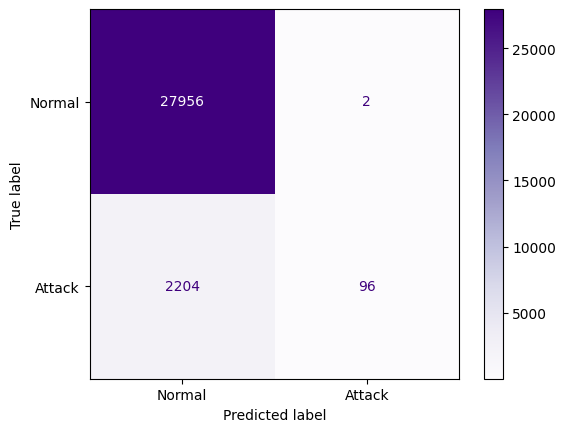

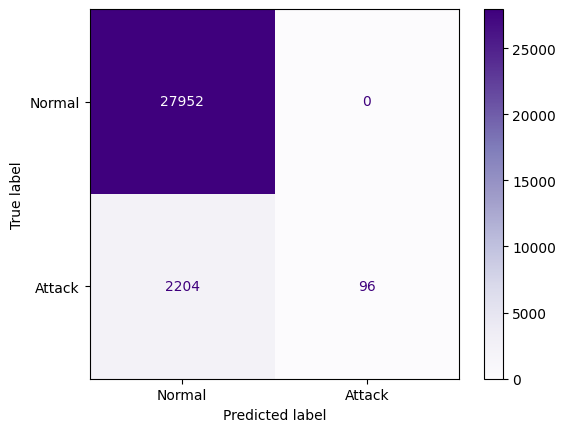

In [ ]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

# Scale the numerical data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_train_full[numerical_features])

# Apply DBSCAN
dbscan = DBSCAN(eps=1.5, min_samples=10, n_jobs=-1)
dbscan.fit(X_scaled)

# DBSCAN labels: -1 = noise (anomaly), others = cluster labels
y_pred_dbscan = dbscan.labels_
y_pred_dbscan_binary = np.where(y_pred_dbscan == -1, 1, 0)  # 1 = Attack, 0 = Normal

# Evaluate against binary ground truth
print("Classification Report (DBSCAN - Binary: Normal vs. Attack):")
print(classification_report(df_train_full['attack'], y_pred_dbscan_binary, target_names=['Normal', 'Attack']))

# Confusion Matrix for training data

print("Confusion matrix for training data")
cm = confusion_matrix(df_train_full['attack'], y_pred_dbscan_binary)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Attack'])
disp.plot(cmap='Purples')

# evaluate on test data
# Scale test data using the same scaler
X_test_scaled = scaler.transform(df_test_full[numerical_features])

# Apply DBSCAN on test data
dbscan_test = DBSCAN(eps=1.5, min_samples=10, n_jobs=-1)
dbscan_test.fit(X_test_scaled)

# Convert DBSCAN labels to binary
y_pred_test_dbscan = dbscan_test.labels_
y_pred_test_dbscan_binary = np.where(y_pred_test_dbscan == -1, 1, 0)  # 1 = Attack, 0 = Normal

# Evaluate against test ground truth
print("Classification Report (DBSCAN - Test Binary: Normal vs. Attack):")
print(classification_report(df_test_full['attack'], y_pred_test_dbscan_binary, target_names=['Normal', 'Attack']))

# Confusion Matrix for test data
print("Confusion matrix for test data")
cm_test = confusion_matrix(df_test_full['attack'], y_pred_test_dbscan_binary)
disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=['Normal', 'Attack'])
disp_test.plot(cmap='Purples')

# accuracy on test data
accuracy = accuracy_score(df_test_full['attack'], y_pred_test_dbscan_binary)
print(f"Accuracy on test data: {accuracy:.4f}")



Classification Report (Agglomerative Clustering - Binary):
              precision    recall  f1-score   support

      Normal       0.93      1.00      0.96     27958
      Attack       1.00      0.02      0.03      2300

    accuracy                           0.93     30258
   macro avg       0.96      0.51      0.50     30258
weighted avg       0.93      0.93      0.89     30258

Accuracy: 0.9252


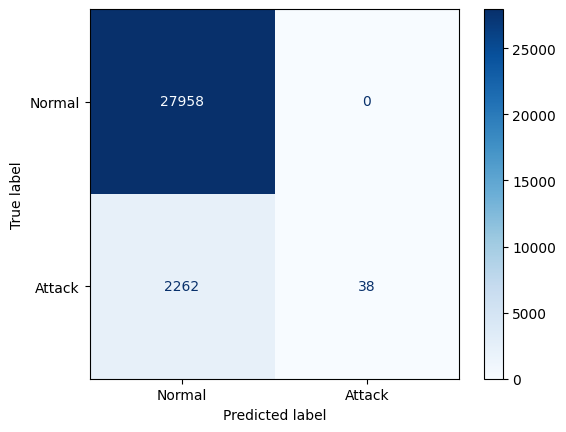

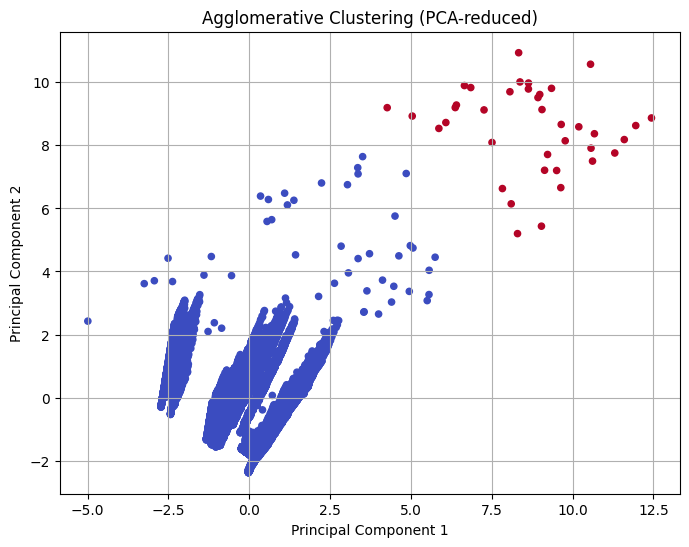

In [ ]:
#heirarcial clustering and PCA
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score

# Step 1: Scale the numerical features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_train_full[numerical_features])

# Step 2: PCA for dimensionality reduction (2D for speed + visualization)
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Step 3: Apply Agglomerative Clustering
agglo = AgglomerativeClustering(n_clusters=2, linkage='average')
y_pred_agglo = agglo.fit_predict(X_pca)

# Step 4: Convert to binary labels (adjust if needed)
y_pred_agglo_binary = np.where(y_pred_agglo == 0, 0, 1)

# Step 5: Evaluate clustering
print("Classification Report (Agglomerative Clustering - Binary):")
print(classification_report(df_train_full['attack'], y_pred_agglo_binary, target_names=['Normal', 'Attack']))
print(f"Accuracy: {accuracy_score(df_train_full['attack'], y_pred_agglo_binary):.4f}")

# Step 6: Confusion Matrix
cm = confusion_matrix(df_train_full['attack'], y_pred_agglo_binary)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Attack'])
disp.plot(cmap='Blues')

# Step 7: Visualize clusters in PCA space
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_pred_agglo_binary, cmap='coolwarm', s=20)
plt.title("Agglomerative Clustering (PCA-reduced)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.grid(True)
plt.show()
